In [ ]:

import base64
import string
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import statsmodels.api as sm

from time import time
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import log_loss
from wordcloud import WordCloud
from pywaffle import Waffle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.text import Text
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from plotnine import *

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('omw-1.4')
    

In [ ]:

def display(to_display):
    print()
    print(to_display)
    print()
    

In [177]:

df = pd.read_csv('./train.csv')

df.columns = df.columns.str.upper()
df['ID'] = df['ID'].str.replace('id', '')
# df.set_index('ID', inplace=True)

display(df.head())



      ID                                               TEXT AUTHOR
0  26305  This process, however, afforded me no means of...    EAP
1  17569  It never once occurred to me that the fumbling...    HPL
2  11008  In his left hand was a gold snuff box, from wh...    EAP
3  27763  How lovely is spring As we looked from Windsor...    MWS
4  12958  Finding nothing else, not even gold, the Super...    HPL



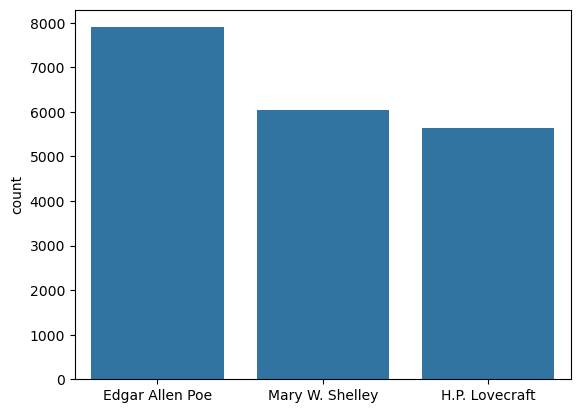

In [178]:

fig = plt.figure()

g = sns.barplot(
    
    x=['Edgar Allen Poe', 'Mary W. Shelley', 'H.P. Lovecraft'],
    y=df['AUTHOR'].value_counts()
    
)


In [176]:

#### Word frequency

def word_frequency(word):
    word_frequency = word.upper() + '_FREQUENCY'
    df[word_frequency] = df['TEXT'].str.lower()
    frequency = df.groupby('AUTHOR')[word_frequency].apply(lambda x: x.str.count(word)).reset_index()
    frequency = frequency[frequency[word_frequency] > 0]
    frequency = frequency.groupby('AUTHOR').agg({word_frequency: 'sum'}).reset_index()
    
    return frequency

def display_waffle(df, word):
    data = {}

    for i, row in df.iterrows():
        author = row['AUTHOR']
        frequency = row[ word + '_FREQUENCY']
        data[author] = frequency
    
    fig = plt.figure(
        
        FigureClass=Waffle,
        rows=15,
        values=data,
        legend={ 'loc': 'upper left', 'bbox_to_anchor': (1, 1) },
        icons='square',
        icon_size=15,
        figsize=(8, 8)
        
    )

    print(' > Frequency by author for word: ' + word)
    plt.show()
    
def get_word_frequency_by_author(word):
    frequency = word_frequency(word)
    display(frequency)
    display_waffle(frequency, word.upper())



  AUTHOR  FEAR_FREQUENCY
0    EAP              72
1    HPL             168
2    MWS             228

 > Frequency by author for word: FEAR


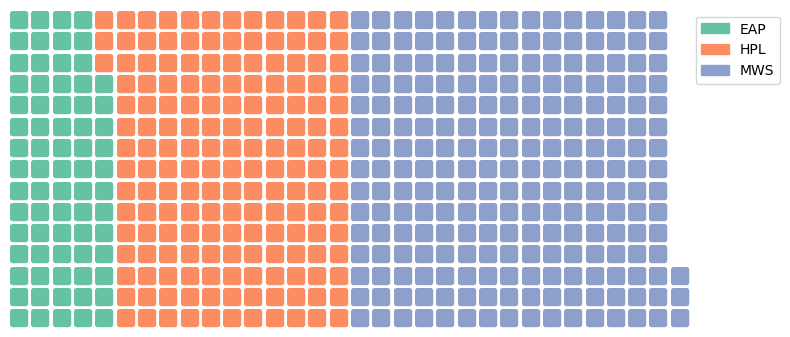

In [88]:

get_word_frequency_by_author('fear')



  AUTHOR  HORROR_FREQUENCY
0    EAP                65
1    HPL               111
2    MWS                60

 > Frequency by author for word: HORROR


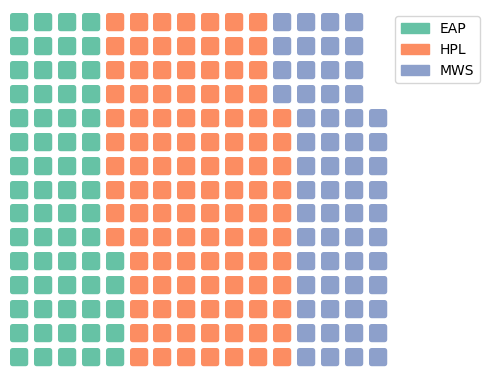

In [85]:

get_word_frequency_by_author('horror')



{'am', 'they', 'ourselves', 'any', 'should', 'about', 'why', 'yourselves', 'some', 'to', "should've", 'weren', "that'll", 'my', 'with', 'having', "aren't", 'as', 'too', 'off', 'while', 'out', 'we', 'don', 'themselves', 'into', 'mustn', 'been', 'o', 'then', 'me', 'how', 'itself', 'll', 'be', 'when', 'only', 'ours', 'she', 'aren', 'hers', "you're", 'your', 'until', "hasn't", "she's", 'because', 'hadn', 'very', 'their', 'or', 'ma', 'same', "don't", 'myself', "mustn't", 'herself', 'it', 'all', "won't", 'has', 'where', 'that', 'hasn', 'him', 'own', 'just', 'at', 'whom', 'haven', 'its', 'wasn', 'for', 'there', 'd', 'shan', 'y', 'so', "mightn't", 'over', 'by', 'those', 'does', 'a', 'wouldn', 'up', 'against', 'no', 'this', 'during', 'her', 'ain', 'above', 'doesn', 'the', 'nor', 'than', 'his', "shouldn't", 'what', 'm', 'further', 'our', "hadn't", "it's", 'and', 'needn', 'them', 'you', 'had', "didn't", 'who', 'again', 'under', 'most', "weren't", 'of', 'being', 'yourself', 'yours', 'such', 'i', 

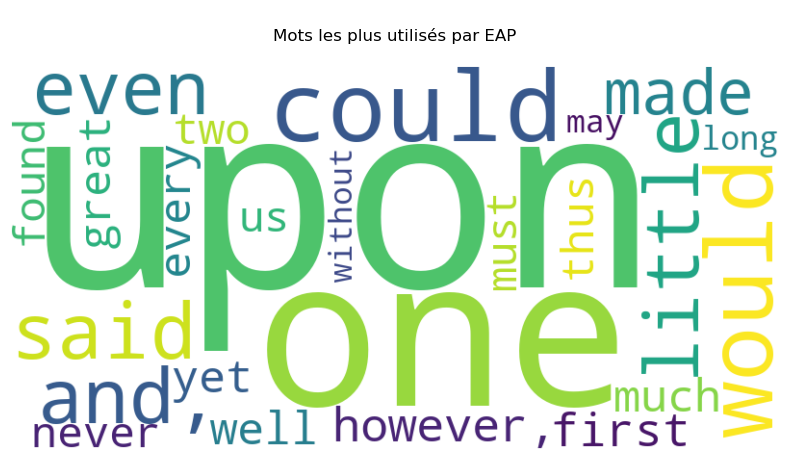

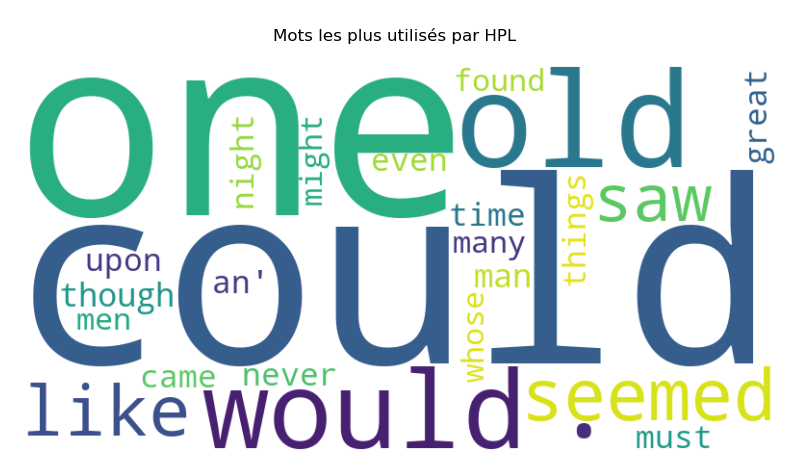

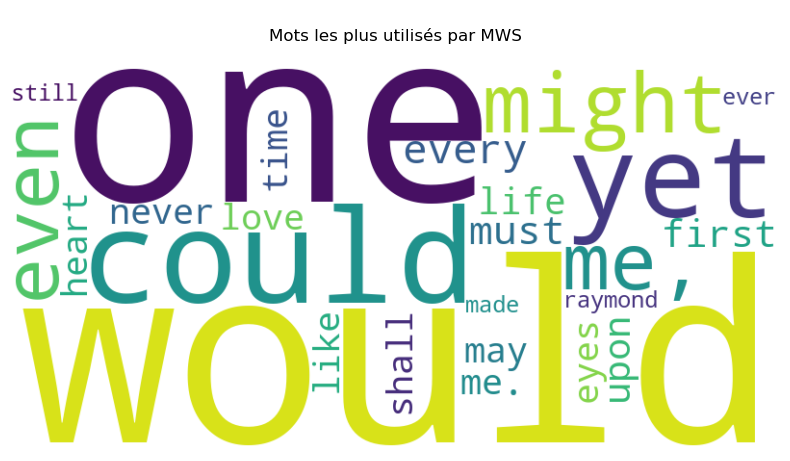

In [179]:

#### Wordcloud

stop_words = set(stopwords.words('english'))

display(stop_words)

def top_words(df):
    top_words_by_author = {}
    for author, group in df.groupby('AUTHOR'):
        texts = ' '.join(group['TEXT']).lower()
        words = texts.split()
        filtered = [word for word in words if word.lower() not in stop_words]
        word_counts = Counter(filtered)
        top_words_by_author[author] = pd.Series(word_counts).sort_values(ascending=False)[:25]
        
    return top_words_by_author

top_words_by_author = top_words(df)

for author, top_words in top_words_by_author.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
    print()
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'\nMots les plus utilisés par { author }\n')
    plt.axis('off')
    plt.show()
    print()


In [ ]:

#### Loi de Zipf

count_words = pd.DataFrame(
    {
        
        'COUNTER': df.groupby('AUTHOR')
            .apply(lambda s: ' '.join(s['TEXT']).split())
            .apply(lambda s: Counter(s))
            .apply(lambda s: s.most_common())
            .explode()
        
    }
)

count_words[['WORD', 'COUNT']] = pd.DataFrame(
    count_words['COUNTER'].tolist(), index=count_words.index
)

count_words = count_words.reset_index()

count_words = count_words.assign(
    
    TOTAL_WORD_BY_AUTHOR = lambda x: (x.groupby('AUTHOR')['COUNT'].transform('sum')),
    frequency = lambda x: x['COUNT'] / x['TOTAL_WORD_BY_AUTHOR'],
    rank = lambda x: x.groupby('AUTHOR')['COUNT'].transform('rank', ascending=False)
    
)


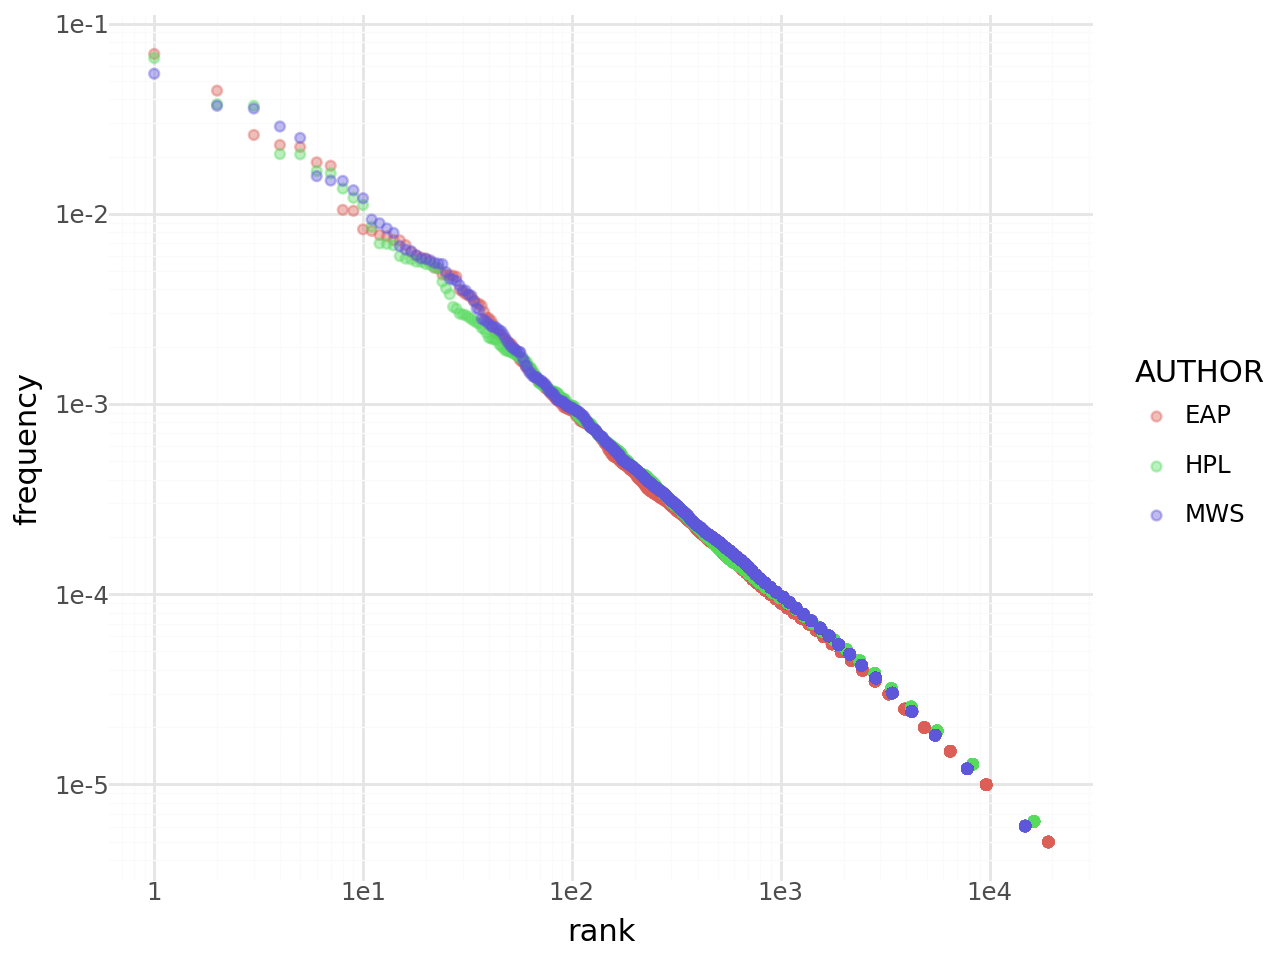

In [110]:

g = (
    
    ggplot(count_words)
        + geom_point(aes(y='frequency', x='rank', color='AUTHOR'), alpha=0.4)
        + scale_x_log10()
        + scale_y_log10()
        + theme_minimal()
    
)

g


In [112]:

exog = sm.add_constant(np.log(count_words['rank'].astype(float)))

model = sm.GLM(
    count_words['frequency'].astype(float), exog, family=sm.families.Poisson()
).fit()

display(model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:              frequency   No. Observations:                69299
Model:                            GLM   Df Residuals:                    69297
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.011
Date:                Tue, 16 Apr 2024   Deviance:                     0.065676
Time:                        13:21:56   Pearson chi2:                   0.0656
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0002431
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4388      1.089     -2.239      0.

In [182]:

#### Cleaning text

def lowercase(text):
    return text.lower()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
    
def tokenize(text):
    return nltk.word_tokenize(text)

def remove_stopwords(words, lang='english'):
    _stopwords = nltk.corpus.stopwords.words(lang)
    return [word for word in words if word not in _stopwords]

def preprocess(text):
    return remove_stopwords(tokenize(remove_punctuation(lowercase(text))))

df['TOKENS'] = df['TEXT'].apply(preprocess)

display(df['TOKENS'])



0        [process, however, afforded, means, ascertaini...
1        [never, occurred, fumbling, might, mere, mistake]
2        [left, hand, gold, snuff, box, capered, hill, ...
3        [lovely, spring, looked, windsor, terrace, six...
4        [finding, nothing, else, even, gold, superinte...
                               ...                        
19574    [could, fancied, looked, eminent, landscape, p...
19575                    [lids, clenched, together, spasm]
19576    [mais, il, faut, agir, say, frenchman, never, ...
19577    [item, news, like, strikes, us, coolly, received]
19578    [laid, gnarled, claw, shoulder, seemed, shakin...
Name: TOKENS, Length: 19579, dtype: object



In [183]:

#### Lemmatize with nltk

lemmatizer = WordNetLemmatizer()

def preprocess_with_lemmatizer(text):
    tokens = remove_stopwords(tokenize(remove_punctuation(lowercase(text))))
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens
    
df['TOKENS'] = df['TEXT'].apply(preprocess_with_lemmatizer)

display(df['TOKENS'])



0        [process, however, afforded, mean, ascertainin...
1        [never, occurred, fumbling, might, mere, mistake]
2        [left, hand, gold, snuff, box, capered, hill, ...
3        [lovely, spring, looked, windsor, terrace, six...
4        [finding, nothing, else, even, gold, superinte...
                               ...                        
19574    [could, fancied, looked, eminent, landscape, p...
19575                     [lid, clenched, together, spasm]
19576    [mais, il, faut, agir, say, frenchman, never, ...
19577      [item, news, like, strike, u, coolly, received]
19578    [laid, gnarled, claw, shoulder, seemed, shakin...
Name: TOKENS, Length: 19579, dtype: object



In [184]:

#### TF-IDF

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['TEXT'])

# display(tfidf_matrix)

abandon_indices = [i for i, text in enumerate(df['TEXT']) if 'abandon' in text.lower()]
abandon_tfidf_scores = tfidf_matrix.getrow(abandon_indices[0])

display(abandon_indices)
display(abandon_tfidf_scores)



[4, 116, 215, 571, 839, 1042, 1052, 1069, 2247, 2317, 2505, 3023, 3058, 3245, 3380, 3764, 3886, 4425, 5289, 5576, 5694, 6812, 7500, 9013, 9021, 9077, 9560, 11229, 11395, 11451, 11588, 11827, 11989, 11998, 12122, 12158, 12189, 13666, 15259, 16516, 16524, 16759, 17547, 18019, 18072, 18126, 18204, 18251]


  (0, 5825)	0.31068475628791714
  (0, 21914)	0.25915955648889555
  (0, 19919)	0.3148981388991499
  (0, 4816)	0.21571596851880911
  (0, 20705)	0.34998476148616126
  (0, 14919)	0.2700837929448337
  (0, 12986)	0.20371949380547905
  (0, 15948)	0.30350628262969986
  (0, 1456)	0.27413783272539627
  (0, 5)	0.2676157519115715
  (0, 21242)	0.30691575710981567
  (0, 8541)	0.2515557222144473
  (0, 9634)	0.2394107348363705



In [223]:

fear_indices = [i for i, text in enumerate(df['TEXT']) if 'fear' in text.lower()]
fear_tfidf_scores = tfidf_matrix[fear_indices]

display(fear_indices)



[58, 99, 162, 176, 182, 190, 228, 300, 333, 360, 422, 598, 630, 679, 702, 721, 758, 809, 821, 824, 839, 920, 928, 939, 964, 1033, 1088, 1293, 1308, 1331, 1366, 1376, 1499, 1507, 1529, 1571, 1635, 1715, 1731, 1744, 1758, 1825, 1881, 1915, 1916, 1990, 2012, 2019, 2090, 2181, 2325, 2337, 2350, 2382, 2404, 2417, 2512, 2644, 2774, 2784, 2803, 2808, 2817, 2820, 2826, 2850, 2861, 2936, 2939, 2965, 2966, 2977, 3012, 3025, 3050, 3095, 3176, 3206, 3212, 3252, 3280, 3300, 3370, 3387, 3431, 3441, 3512, 3521, 3549, 3583, 3668, 3711, 3716, 3736, 3768, 3769, 4003, 4007, 4008, 4205, 4315, 4336, 4370, 4397, 4399, 4452, 4486, 4588, 4690, 4701, 4757, 4774, 4788, 4863, 4897, 4919, 4921, 4957, 5016, 5093, 5155, 5177, 5239, 5277, 5280, 5290, 5322, 5343, 5394, 5458, 5502, 5513, 5525, 5624, 5653, 5700, 5772, 5845, 5849, 5878, 5888, 5912, 5925, 5932, 5944, 6017, 6024, 6038, 6076, 6145, 6185, 6227, 6248, 6331, 6367, 6373, 6417, 6427, 6662, 6783, 6947, 7061, 7062, 7101, 7111, 7156, 7198, 7207, 7243, 7317, 7406,

In [225]:

fear_tfidf_scores = tfidf_matrix[fear_indices]

def get_top_text_with_word(word, method='avg', top=10):
    indices = [i for i, text in enumerate(df['TEXT']) if word in text.lower()]
    tfidf_scores = tfidf_matrix[indices]
    
    scores = []
    for index, score in zip(indices, tfidf_scores):
        if method == 'avg':
            scores.append((index, sum(score.data) / len(score.data)))
        else: 
            # max for all others values of method
            scores.append((index, max(score.data)))

    tops = sorted(scores, key=lambda x: x[1], reverse=True)[:top]
    sentences = []
    for idx, score in tops:
        sentences.append(df.iloc[idx]['TEXT'])

    return sentences

display(get_top_text_with_word('fear'))
display(get_top_text_with_word('fear', 'max'))
display(get_top_text_with_word('fear', top=20))
    


['Already she fears for us.', 'Be of heart and fear nothing.', '"And now I do not fear death.', 'Indeed I had no fear on her account.', 'We could not fear we did not.', 'I smiled, for what had I to fear?', 'Most fearfully, fearfully this is indeed no dream.', 'We feared the coming summer.', 'Beware, for I am fearless and therefore powerful.', 'I have not the slightest fear for the result.']


['Already she fears for us.', 'Most fearfully, fearfully this is indeed no dream.', 'I smiled, for what had I to fear?', 'Do I fear, that my heart palpitates?', 'We could not fear we did not.', 'Indeed I had no fear on her account.', '"And now I do not fear death.', 'Be of heart and fear nothing.', 'At last came that which I had long feared.', 'I feared no man, and loved none.']


['Already she fears for us.', 'Be of heart and fear nothing.', '"And now I do not fear death.', 'Indeed I had no fear on her account.', 'We could not fear we did not.', 'I smiled, for what had I to fear?', 'Most fearful

In [255]:

#### N-grams && fear context

def get_top_collocations_with_word(word, top=10):
    all_text = ' '.join(df['TEXT'])
    tokens = word_tokenize(all_text)
    finder = BigramCollocationFinder.from_words(tokens)
    bigram_measures = BigramAssocMeasures()
    all_collocations = finder.score_ngrams(bigram_measures.likelihood_ratio)
    word_collocations = [(bigram, score) for bigram, score in all_collocations if word in bigram]
    
    scores = []
    for collocation in word_collocations:
        scores.append(collocation)

    tops = sorted(scores, key=lambda x: x[1], reverse=True)[:top]
    collocations = []
    for bigram, score in tops:
        collocations.append(bigram)

    return collocations

display(get_top_collocations_with_word('fear'))
    


[('lurking', 'fear'), ('I', 'fear'), ('fear', 'lest'), ('fear', 'of'), ('fear', 'that'), ('fear', ','), ('unutterable', 'fear'), ('through', 'fear'), ('Acherontic', 'fear'), ('fear', 'eclipses')]

